# Chromatic Number of Random Graphs

Let a random graph G with parameters (n,p) be a graph with n vertices where every possible edge has probability p of being chosen. Here, we sample the distribution of the chromatic number (minimum coloring size) of these random graphs.

In [1]:
from mip import *
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 

Using Python-MIP package version 1.6.7


In [2]:
from matplotlib import animation
from pylab import rcParams

rcParams['animation.html'] = 'html5'
rcParams['figure.figsize'] = 9, 4

The function below samples the edge set of a random graph (n, p)

In [3]:
def Gnp(n, p):
    E = [(i,j) for i in range(n) for j in range(n) if i < j and np.random.binomial(1, p, 1)]
    return E

We than create a function to sample the distribution of any feature of random graphs.

In [4]:
### Yeah yeah, I know, not the most effiencient memory usage here

def sample(n, step, N, fun, maxi):
    ps = np.arange(step, 1, step)
    res = np.zeros((len(ps), maxi+1))
    
    for i in range(len(ps)):
        for j in range(N):
            E = Gnp(n, ps[i])
            k = int(fun(E, n, verbose=False))
            res[i, k] += 1/N
    
    return res

And, using MIP we can model the minimum coloring problem:

In [5]:
def chromatic(E, n, verbose=True):
    m = Model()
    y = [m.add_var(var_type=BINARY) for j in range(n)]
    x = [[m.add_var(var_type=BINARY) for k in range(n)] for i in range(n)]
    
    for i in range(n):
        m += xsum(x[i][k] for k in range(n)) == 1
        
    for k in range(n):
        for e in E:
            m += x[e[0]][k] + x[e[1]][k] <= 1
    
    for i in range(n):
        for k in range(n):
            m += x[i][k] <= y[k]
                
    m.objective = xsum(y[k] for k in range(n))
    m.max_gap = 0.01
    m.emphasis = 2
    status = m.optimize()
    
    if verbose:
        if status == OptimizationStatus.OPTIMAL:
            print('optimal solution cost {} found'.format(m.objective_value))
        elif status == OptimizationStatus.FEASIBLE:
            print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
        elif status == OptimizationStatus.NO_SOLUTION_FOUND:
            print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
        elif status == OptimizationStatus.INFEASIBLE:
            print('INFEASIBLE'.format(m.objective_bound))
    
    return m.objective_value

Than we just let the model run (and save it because it takes a lot of time)

In [ ]:
res = sample(10, 0.01, 1000, chromatic, 10)
np.save("chromatica_n10.npy", res)

In [6]:
res = np.load("chromatica_n10.npy")

Here we have a heatmap of the distributions. X axis is the chromatic number, Y axis the value of p, and the color is the sample probability. n = 10

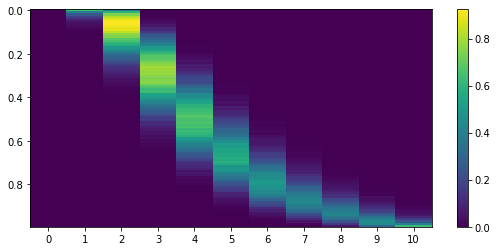

In [7]:
n = 10
step = 0.01
ps = np.arange(step, 1, step)
fig, ax = plt.subplots(1,1)
img = plt.imshow(res, interpolation='nearest', aspect='auto') 

ax.set_xticks(np.arange(0, n+1, 1))
ax.set_xticklabels(np.arange(0, n+1, 1))

ax.set_yticks(np.arange(0, len(ps), len(ps)/5))
ax.set_yticklabels(np.round(np.arange(0, 1, 1/5),2))

fig.colorbar(img)
plt.show()

For a better visualization, an animation (X axis chromatic number, Y axis sample probability):

In [8]:
%matplotlib agg

fig = plt.figure()
ax = fig.gca()
frames = 99

x = range(0, 11)
rects = plt.bar(x, res[0,:], color='orange')
plt.ylim(0, np.max(res))

def animate(i):
    data = res[i,:]
    for rect, yi in zip(rects, data):
        rect.set_height(yi)
    ax.set_title("p: {}".format(np.round(i*step,2)), loc='right')
    return rects

%matplotlib inline
anim = animation.FuncAnimation(fig, animate, frames=frames, interval=150)
anim

No one has found a closed formula for this distribution yet, but a lot of work has been done in the subject.

We could also sample any other graph feature to check how the distribution looks like, or even use different models for random graphs. Maybe in the future.